## How to read EEG data

In [1]:
import os
os.chdir('../src_code')

import numpy as np
import mne
import seaborn as sns
import scipy
import torch
import matplotlib.pyplot as plt
from utils.read_data import read_eeg_data

Read edf file in data folder and plot the EEG data.

In [2]:
SAMPLE_DATA_FOLDER = '../eeg_data/'
file = f'{SAMPLE_DATA_FOLDER}/Subject00_1.edf' # choose one random file

# read data
data = mne.io.read_raw_edf(file, preload=True)

Extracting EDF parameters from e:\Documents\DSSC\Analysis-of-EEG-during-mental-arithmetic-tasks\eeg_data\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


In [3]:
# get datainfo
data.info

Measurement date,"January 01, 2011 00:00:00 GMT"
Experimenter,Unknown
Participant,0
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.50 Hz
Lowpass,45.00 Hz


Using matplotlib as 2D backend.


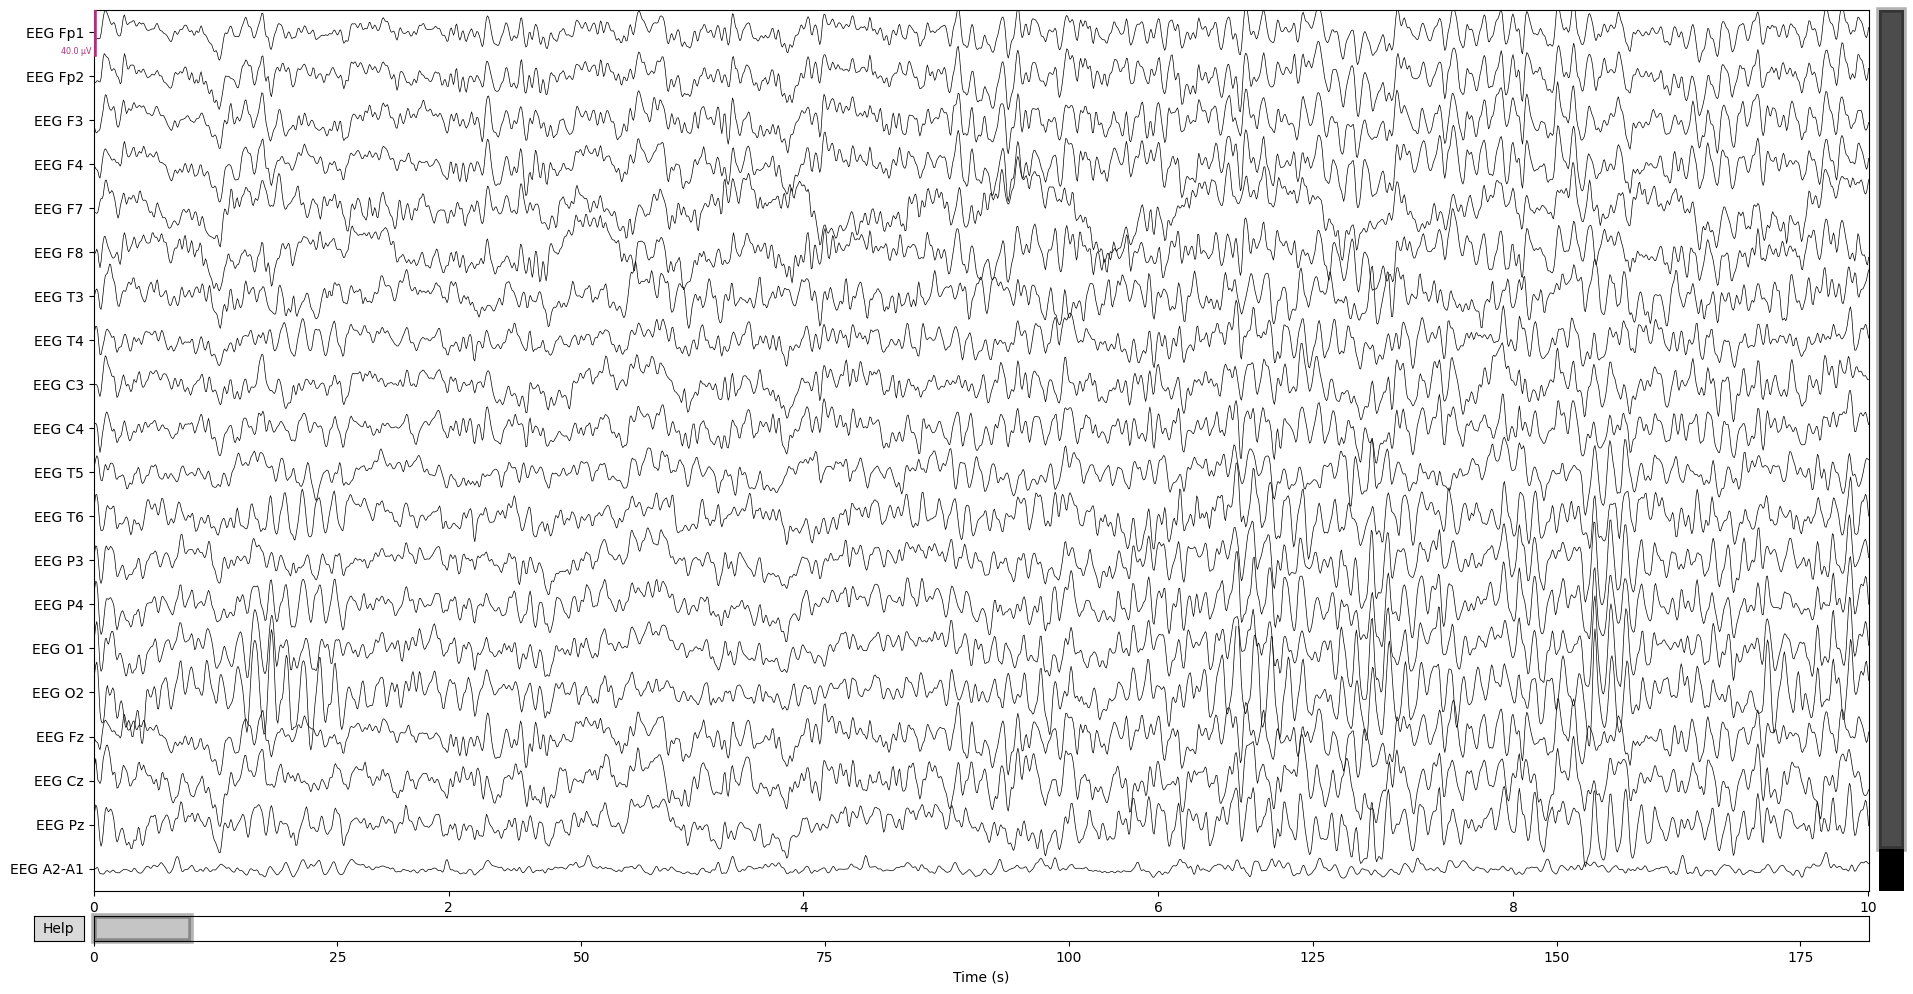

In [4]:
# plot raw data
data.plot();

In [5]:
# retrieve channel names
data.ch_names

['EEG Fp1',
 'EEG Fp2',
 'EEG F3',
 'EEG F4',
 'EEG F7',
 'EEG F8',
 'EEG T3',
 'EEG T4',
 'EEG C3',
 'EEG C4',
 'EEG T5',
 'EEG T6',
 'EEG P3',
 'EEG P4',
 'EEG O1',
 'EEG O2',
 'EEG Fz',
 'EEG Cz',
 'EEG Pz',
 'EEG A2-A1',
 'ECG ECG']

In [3]:
# print data shape (n_channels, n_samples)
print(data.get_data().shape)
# raw data can be accessed by channel name as well
print(len(data['EEG Fp1'][0][0]))

(21, 91000)
91000


EEG Fz and EEG T4


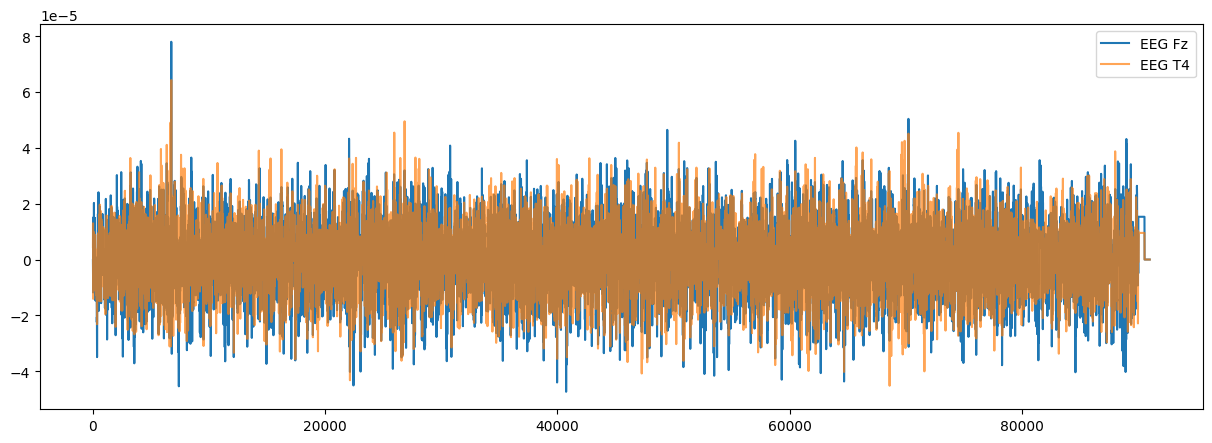

In [4]:
# plot two random channels one above the other
import matplotlib.pyplot as plt

# get idx of two random channels
idx1 = np.random.randint(0, len(data.ch_names))
idx2 = np.random.randint(0, len(data.ch_names))
print(f'{data.ch_names[idx1]} and {data.ch_names[idx2]}')

ch1 = data.get_data()[idx1]
ch2 = data.get_data()[idx2]
plt.figure(figsize=(15, 5))
plt.plot(ch1, label=data.ch_names[idx1])
plt.plot(ch2, label=data.ch_names[idx2], alpha=0.7)

plt.legend()
plt.show()

Visualize two recordings (Rest state and counting state) of the same subject as raw EEG data and corresponding frequency domain data.

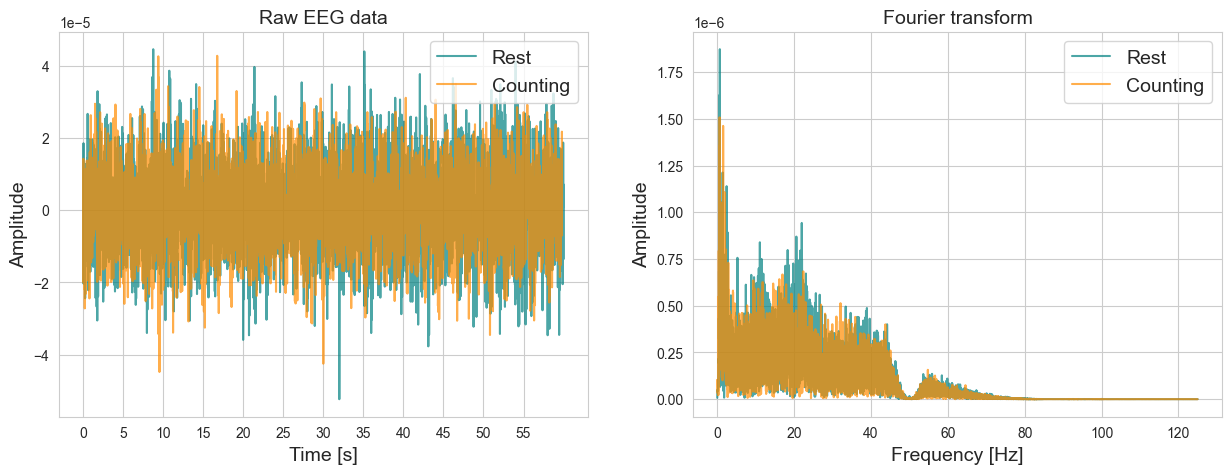

In [5]:
sns.set_style('whitegrid')

subj = 2
file1 = f'../eeg_data/Subject{subj:02}_1.edf'
file2 = f'../eeg_data/Subject{subj:02}_2.edf'

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
data1 = mne.io.read_raw_edf(file1, preload=True, verbose=False)
data2 = mne.io.read_raw_edf(file2, preload=True, verbose=False)


# get data from channel 0
sample1 = data1.get_data(0)[0][:30000]
sample2 = data2.get_data(0)[0]

fontsize = 14
# plot raw data
plt.plot(sample1, label='Rest', alpha=0.7, color='teal')
plt.plot(sample2[:29900], label='Counting', alpha=0.7, color='darkorange')
# change ticks to seconds
plt.xticks(np.arange(0, 30000, 2500), np.arange(0, 60, 5))

plt.title('Raw EEG data', fontsize=fontsize)
plt.xlabel('Time [s]', fontsize=fontsize)
plt.ylabel('Amplitude', fontsize=fontsize)

plt.legend(fontsize=fontsize, loc='upper right')

plt.subplot(1,2,2)

# get fourier transform
yf = scipy.fft.fft(sample1)
N = len(sample1)
T = 1/500.0
xf = scipy.fft.fftfreq(N, T)[:N//4]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//4]), label='Rest', alpha=0.7, color='teal')

yf = scipy.fft.fft(sample2)
N = len(sample2)
T = 1/500.0
xf = scipy.fft.fftfreq(N, T)[:N//4]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//4]), label='Counting', alpha=0.7, color='darkorange')
plt.title('Fourier transform', fontsize=fontsize)

plt.xlabel('Frequency [Hz]', fontsize=fontsize)
plt.ylabel('Amplitude', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


### Building dataset

MNE functions have been used for building datasets to be used throughout all this project.
Functions to read EEG data and build datasets are available in *utils/read_data.py*.

The following cells show how to build a dataset from the raw EEG data and how to access the data.

In [6]:
DATASET_FOLDER = './saved_datasets/'
number_of_subjects = 5
number_of_channels = 20
classification = 'ms'
time_window = 1

dataset = read_eeg_data(SAMPLE_DATA_FOLDER, DATASET_FOLDER, input_channels=number_of_channels, number_of_subjects=number_of_subjects, type = classification, save_spec=True, time_window=time_window)
    
print("\nLength of dataset: ", len(dataset))
print("Number_of_channels: ", len(dataset.raw[0]))

INFO:utils.utils:Loading dataset...



Length of dataset:  600
Number_of_channels:  20


Each raw EEG segment is a 1D array of fs * T values, where fs is the sampling frequency and T is the duration of the segment in seconds. The data is recorded from 20 electrodes, so the shape of the data is (20, fs * T). The number of dataitems instead is given by the number of subjects * number of segments per subject.

In [7]:
raw_data = np.array(dataset.raw)
print(raw_data.shape)

(600, 20, 500)


Print shape of the first (resampled) spectrogram: (nchannels, freqs, timepoints)

In [8]:
dataset.get_spectrogram(0).shape

(20, 30, 200)

Plot spectrogram corresponding to the first channel of the first dataitem.

Label: 0
Id: Subject00_1_0


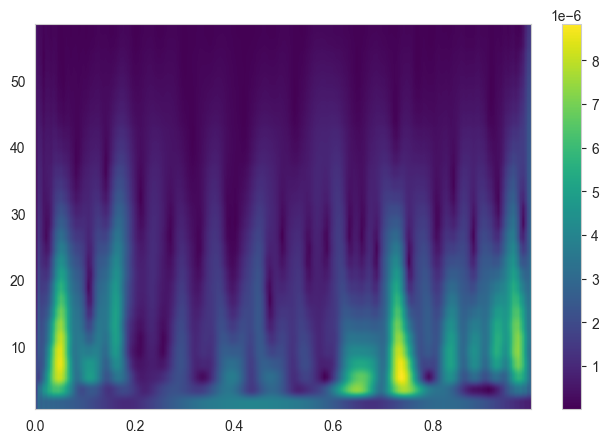

In [17]:
# plot spectrogram
idx = 0
print('Label:', dataset.get_label(idx)) 
print('Id:', dataset.get_id(idx)[0])

freqs = np.arange(0.5, 60, 2)
times = np.arange(0, len(dataset.raw[0][0])/500, 1/500)
plt.figure(figsize=(8,5))
plt.imshow(dataset.get_spectrogram(idx)[0,:,:], aspect='auto', origin='lower', extent=[times[0], times[-1], freqs[0], freqs[-1]], cmap='viridis')
plt.grid(False)
plt.colorbar()
plt.show()


Plot corresponding raw EEG data.

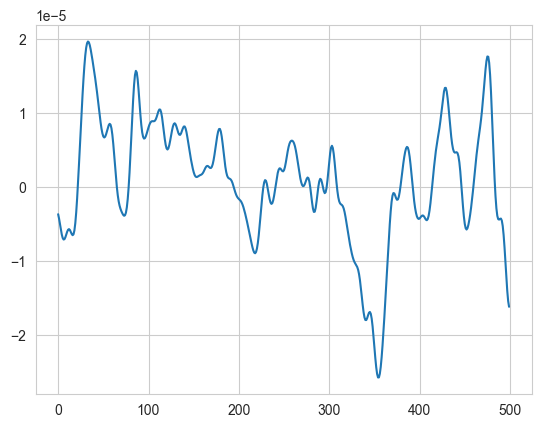

In [18]:
raw = dataset.raw[idx][0]
plt.plot(raw)
plt.show()